In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
%load_ext rpy2.ipython

In [3]:
%%capture
%%R
#capture to avoid seeing all the loading/install messages 
#%%capture basically avoids any stdout/stderr on the cell
if (!require("ggplot2")) install.packages('ggplot2')
if (!require("forecast")) install.packages('forecast')
if (!require("tidyverse")) install.packages('tidyverse')
if (!require("KFAS")) install.packages('KFAS')
if (!require("data.table")) install.packages('data.table')
if (!require("timeDate")) install.packages('timeDate')
if (!require("xts")) install.packages('xts')


In [4]:
#%%R

#library("ggplot2")
#library("forecast")
#library("tidyverse")
#library("KFAS")

#if having problem with forecast package:
#!sudo rm -rf /usr/local/lib/R/site-library/00LOCK-RcppArmadillo
#and rexecute the cell above, otherwise use R by typing !R in a new cell
#and correct the error manually

In [5]:
%%R 

path <- "data/"
#path <- "/content/drive/My Drive/ts_proj/"

df <- read.csv2(paste0(path,"time_series_dataset.csv"), dec = ".")
df$Data <- as.Date(df$Data)

print(head(df))

        Data     value
1 2010-01-01  41.65104
2 2010-01-02 131.28660
3 2010-01-03 117.38812
4 2010-01-04 116.46128
5 2010-01-05 123.82376
6 2010-01-06 104.28556


Splittiamo il dataset in train e test per verificare come va il modello su nuovi dati.

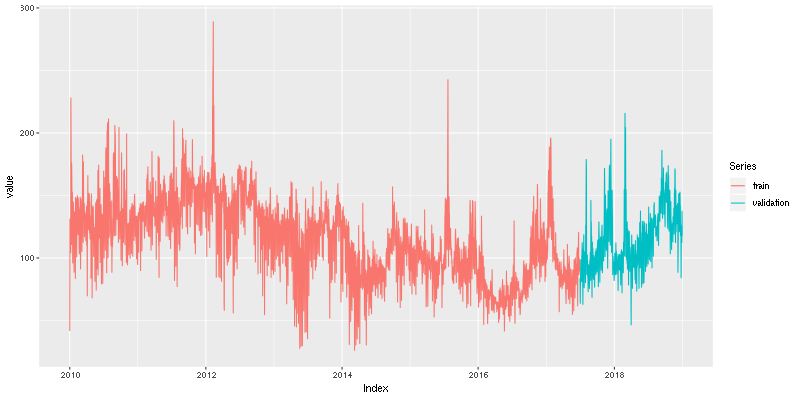

In [6]:
%%R -w 800 -h 400
idata <- xts(df$value, start=c(2010,1), order.by=df$Data) 

train <- idata["2010-01-01/2017-06-30"]
validation <- idata["2017-07-01/2018-12-31"]

autoplot(cbind(train, validation), facet=NULL) + ylab("value")

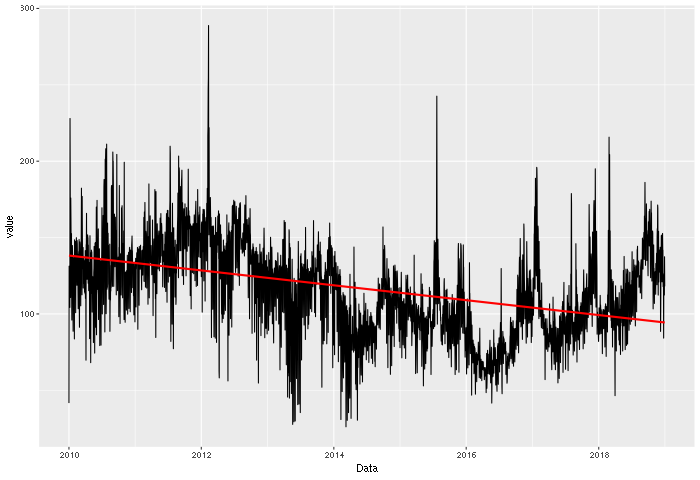

In [7]:
%%R -w 700
ggplot(data = df, aes(x = Data, y = value)) + 
    geom_line(color='black') +
    geom_smooth(method = "lm", se = FALSE, col="red")

# ARIMA with R

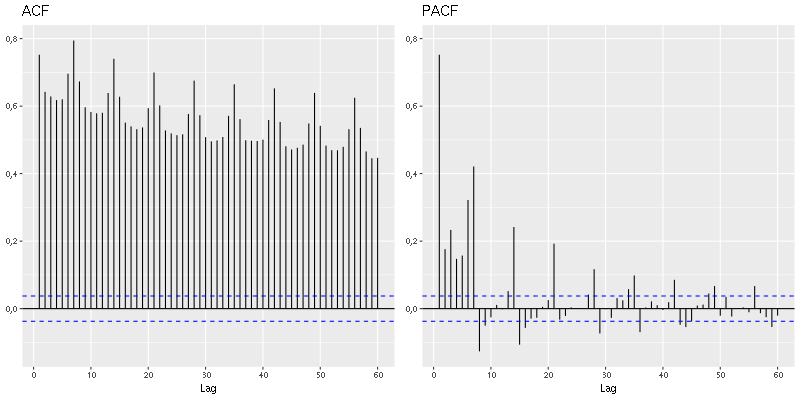

In [8]:
%%R -w 800 -h 400
## ------------------------------------------------------------------------
#This is the function ggtsdisplay of forecast package, 
#but it has been modified so is doesn't plot the series,
#just the ACF and PACF plot, with the horizontal parameter 
#the plot can be either horizontal or vertical
#The function has been simplified a lot, since we don't need 
#all the complexity the original one has.
ggtsdisplay_2 <- function(x, lag.max, horizontal=TRUE, ...) {
    if (!is.ts(x)) {
      x <- ts(x)
    }
    if (missing(lag.max)) {
      lag.max <- round(min(max(10 * log10(length(x)), 3 * frequency(x)), length(x) / 3))
    }
    ######      END   CHECKING    ########
    
    # Set up grid for plots
    if (horizontal){
      gridlayout <- matrix(c(2, 3), nrow = 1)
    }
    else{
      gridlayout <- matrix(c(2, 3), nrow = 2)
    }
    grid::grid.newpage()
    grid::pushViewport(grid::viewport(layout = grid::grid.layout(nrow(gridlayout), ncol(gridlayout))))
    
    # Prepare Acf plot
    acfplot <- do.call(ggAcf, c(x = quote(x), lag.max = lag.max)) +
      ggplot2::ggtitle("ACF") + ggplot2::ylab(NULL)

    # Prepare last plot (variable)
    pacfplot <- ggPacf(x, lag.max = lag.max) + ggplot2::ggtitle("PACF") +
      ggplot2::ylab(NULL)
    # Match y-axis
    acfplotrange <- ggplot2::layer_scales(acfplot)$y$range$range
    pacfplotrange <- ggplot2::layer_scales(pacfplot)$y$range$range
    yrange <- range(c(acfplotrange, pacfplotrange))
    acfplot <- acfplot + ggplot2::ylim(yrange)
    pacfplot <- pacfplot + ggplot2::ylim(yrange)

    # Add ACF plot
    matchidx <- as.data.frame(which(gridlayout == 2, arr.ind = TRUE))
    print(
      acfplot,
      vp = grid::viewport(
        layout.pos.row = matchidx$row,
        layout.pos.col = matchidx$col
      )
    )

    # Add PACF plot
    matchidx <- as.data.frame(which(gridlayout == 3, arr.ind = TRUE))
    print(
      pacfplot,
      vp = grid::viewport(
        layout.pos.row = matchidx$row,
        layout.pos.col = matchidx$col
      )
    )
  
}

ggtsdisplay_2(train, horizontal = TRUE, lag.max = 60)


Series: train 
ARIMA(0,0,0)(1,0,1)[7] with non-zero mean 
Box Cox transformation: lambda= 0,9742241 

Coefficients:
        sar1     sma1      mean
      0,9598  -0,5488  104,4242
s.e.  0,0065   0,0238    3,1736

sigma^2 estimated as 245:  log likelihood=-11419,73
AIC=22847,46   AICc=22847,48   BIC=22871,12


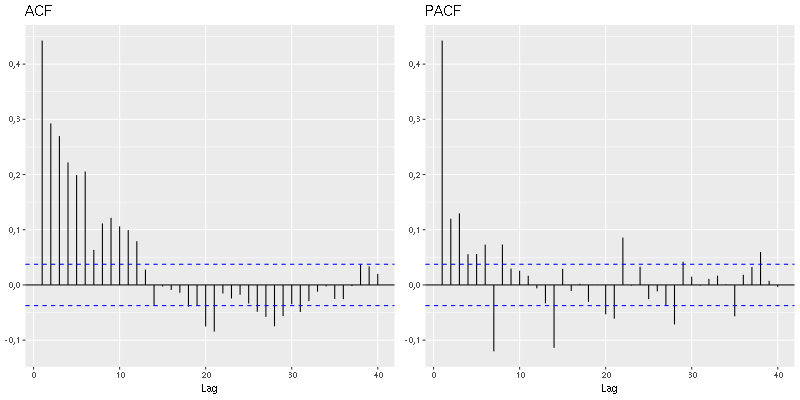

In [9]:
%%R -w 800 -h 400
mod1 <- Arima(train, c(0,0,0), list(order=c(1,0,1), period=7), lambda = "auto")
ggtsdisplay_2(mod1$residuals, lag.max = 40)
mod1

Vediamo anche che il coefficiente di SAR è molto vicino ad 1, quindi ha radice unitaria e ciò dice che esiste l'integrazione stagionale che sospettavamo prima. E il grafico del ACF e PACF mostrano ancora dei residui che sembrano un MA(6) (visti i primi 6 picchi di AR molto alti) e un AR(x) con x da trovare, ma allo stesso momento sembrano esserci delle anomalie per poter dire con sicurezza che sia un certo ARMA(x,6), forse c'è una compenente anche dell'integrazione non stagionale (perché la serie sembra avere un minimo di trend), quindi proviamo a vedere quale modello massimizza la log likelihood dove il modello sarà un ARMA$(p,q)$ con $p=0,...,6$ e $q=0,...,6$ insieme al SARIMA$(1,1,1)_7$ già trovato prima.

E' una sorta di GRID SEARCH sul modello ARIMA. Per il momento trascuriamo la parte dell'integrazione e ci pensiamo dopo aver trovato il modello ARMA migliore.

In [10]:
%%R
#checking the arributes an ARIMA object has, to find the log likelihood one.
attributes(mod1)

$names
 [1] "coef"      "sigma2"    "var.coef"  "mask"      "loglik"    "aic"      
 [7] "arma"      "residuals" "call"      "series"    "code"      "n.cond"   
[13] "nobs"      "model"     "aicc"      "bic"       "lambda"    "x"        
[19] "fitted"   

$class
[1] "forecast_ARIMA" "ARIMA"          "Arima"         



In [11]:
%%time
%%R

best_mod <- Arima(train, c(0,0,0), list(order=c(1,1,1), period=7), 
                  lambda = "auto")
best_loglik <- best_mod$loglik

for (i in 0:6){
    for (j in 0:6){
        tryCatch({
            temp_mod <- Arima(train, c(i,0,j), list(order=c(1,1,1), period=7), 
                          lambda = "auto")
            temp_mod_loglik <- temp_mod$loglik
            if (best_loglik < temp_mod$loglik){
                best_mod <- temp_mod
                best_loglik <- temp_mod$loglik
            } 
        }, error=function(e){temp_mod_loglik <- 99999})
        print(paste0("AR-",i," MA-",j,
                     " -- LOG_LIKE:",temp_mod_loglik, " --BEST:",best_loglik), 
              flush=TRUE)
    }
}

[1] "AR-0 MA-0 -- LOG_LIKE:-11375,7006117445 --BEST:-11375,7006117445"
[1] "AR-0 MA-1 -- LOG_LIKE:-11142,8592016978 --BEST:-11142,8592016978"
[1] "AR-0 MA-2 -- LOG_LIKE:-11092,8617455839 --BEST:-11092,8617455839"
[1] "AR-0 MA-3 -- LOG_LIKE:-11048,2675212404 --BEST:-11048,2675212404"
[1] "AR-0 MA-4 -- LOG_LIKE:-11022,3348619649 --BEST:-11022,3348619649"
[1] "AR-0 MA-5 -- LOG_LIKE:-11014,148578925 --BEST:-11014,148578925"
[1] "AR-0 MA-6 -- LOG_LIKE:-10940,4853263174 --BEST:-10940,4853263174"
[1] "AR-1 MA-0 -- LOG_LIKE:-11034,9166639061 --BEST:-10940,4853263174"
[1] "AR-1 MA-1 -- LOG_LIKE:-10929,9401611245 --BEST:-10929,9401611245"
[1] "AR-1 MA-2 -- LOG_LIKE:-10895,1826123982 --BEST:-10895,1826123982"
[1] "AR-1 MA-3 -- LOG_LIKE:-10895,1227201411 --BEST:-10895,1227201411"
[1] "AR-1 MA-4 -- LOG_LIKE:-10894,9476766266 --BEST:-10894,9476766266"
[1] "AR-1 MA-5 -- LOG_LIKE:-10894,9475953037 --BEST:-10894,9475953037"
[1] "AR-1 MA-6 -- LOG_LIKE:-10890,7799506615 --BEST:-10890,7799506615"
[1] "AR-

CPU times: user 7min 32s, sys: 21.3 s, total: 7min 53s
Wall time: 7min 23s


In [12]:
%%R

xts_to_ts <- function(x, start="2010-01-01"){
    n <- length(x)
    ind <- as.numeric(index(x) - as.Date(start))
    tsx <- ts(x, start=ind[1]+1, end=ind[n]+1, frequency=frequency(x))
    tsx
}

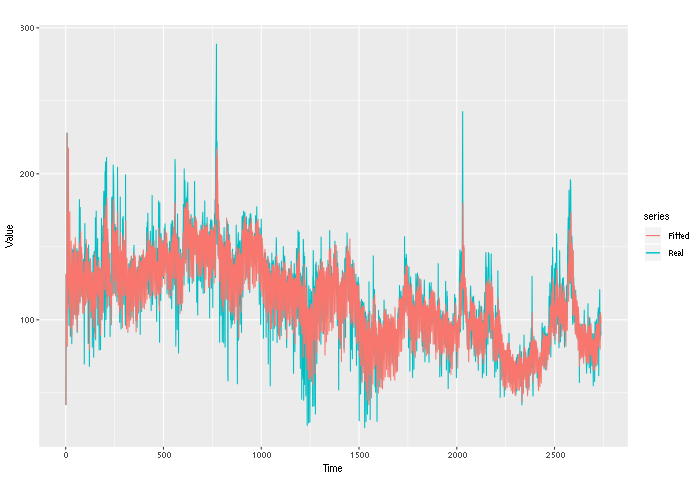

In [13]:
%%R -w 700

autoplot(xts_to_ts(train), series="Real")+
  autolayer(best_mod$fitted, series="Fitted")+
  ylab("Value")

In [14]:
%%R
best_mod #is ARMA(6,6)

Series: train 
ARIMA(6,0,6)(1,1,1)[7] 
Box Cox transformation: lambda= 0,9742241 

Coefficients:
         ar1     ar2     ar3     ar4      ar5      ar6      ma1      ma2
      0,6468  0,0744  0,2671  0,6543  -0,3382  -0,3129  -0,2548  -0,1173
s.e.  0,1784  0,1737  0,1365  0,1339   0,1673   0,1039   0,1759   0,1223
          ma3      ma4     ma5     ma6    sar1     sma1
      -0,2094  -0,7198  0,0419  0,3526  0,1313  -0,9697
s.e.   0,1007   0,0969  0,1504  0,0651  0,0291   0,0062

sigma^2 estimated as 168,9:  log likelihood=-10880,31
AIC=21790,63   AICc=21790,81   BIC=21879,31


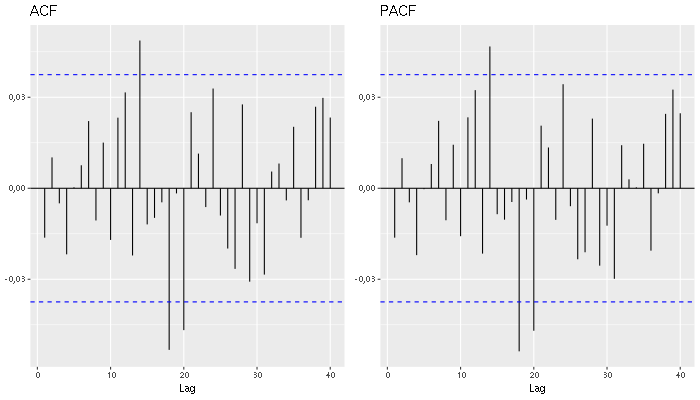

In [15]:
%%R -w 700 -h 400
ggtsdisplay_2(best_mod$residuals, lag.max = 40)

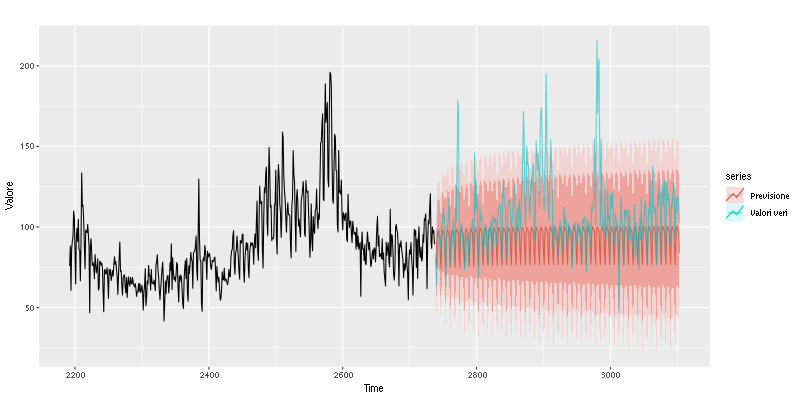

In [16]:
%%R -w 800 -h 400
pred <- forecast(best_mod, h=365)

autoplot(xts_to_ts(idata["2016-01-01/2017-06-30"])) +
  autolayer(pred,series="Previsione", alpha=0.7) +
  autolayer(xts_to_ts(validation["2017-07-01/2018-06-30"]), series="Valori veri", alpha=0.6) +
  xlab("Time") +
  ylab("Valore")

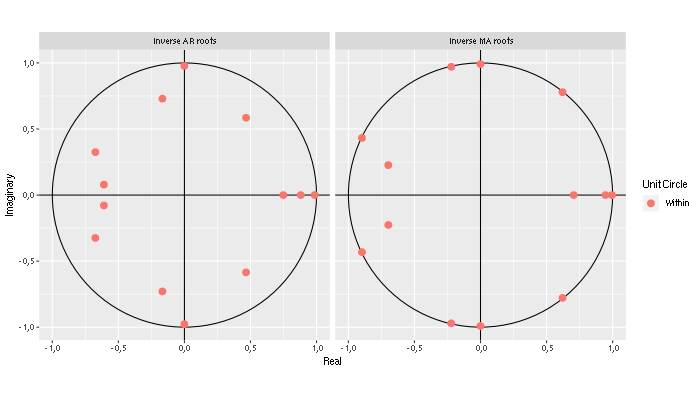

In [17]:
%%R -w 700 -h 400
autoplot(best_mod)

In [18]:
%%R
Mod(1/polyroot(c(1,-best_mod$coef[1:6])))

[1] 0,9773155 0,9858065 0,9773155 0,8808149 0,6142705 0,6142705


Modulo delle radici troppo vicino ad 1, significa che bisogna integrare (in effetti un po' di trend si vedeva sin dall'inizio). Iniziamo con integrazione del primo ordine, se non basta si proverà anche del secondo ordine.

Series: train 
ARIMA(6,1,6)(1,1,1)[7] 
Box Cox transformation: lambda= 0,9742241 

Coefficients:
          ar1      ar2      ar3      ar4     ar5     ar6     ma1      ma2
      -0,6830  -0,3886  -0,1617  -0,0121  0,1525  0,2552  0,0833  -0,2015
s.e.   0,1144   0,1518   0,1238   0,1305  0,0842  0,0431  0,1162   0,1122
          ma3      ma4      ma5      ma6    sar1     sma1
      -0,1894  -0,1758  -0,2276  -0,1139  0,2842  -0,9761
s.e.   0,1082   0,1425   0,0852   0,0953  0,0317   0,0052

sigma^2 estimated as 170,2:  log likelihood=-10889,81
AIC=21809,61   AICc=21809,79   BIC=21898,29


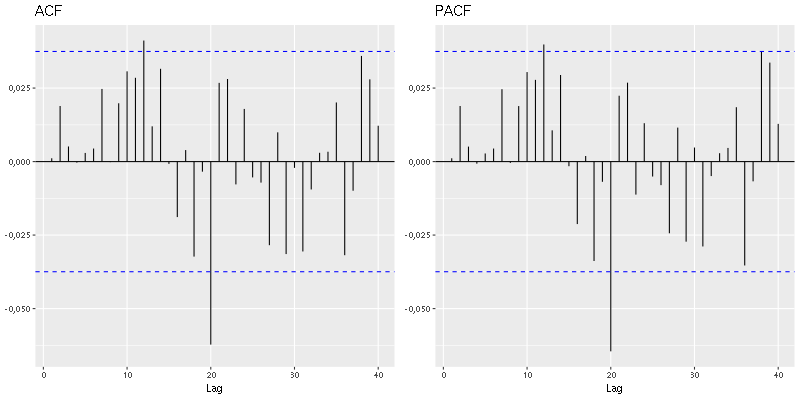

CPU times: user 39.2 s, sys: 602 ms, total: 39.8 s
Wall time: 39 s


In [19]:
%%time
%%R -w 800 -h 400
mod2 <- Arima(train, c(6,1,6), list(order=c(1,1,1), period=7), 
                          lambda = "auto")

ggtsdisplay_2(mod2$residuals, lag.max = 40)
mod2

I residui sembrano essere rientrati nella banda tranne un piccolo residuo a 20 sia un ACF che PACF.

Usiamo il test Augmented Dickey-Fuller, che cerca radici unitarie nella serie, per verificare se la serie è stazionaria, con k che indica il ritardo autoregressivo, $H_0$ è la presenza di radici unitarie nella serie, $H_1$ è che la serie è stazionaria.


	Augmented Dickey-Fuller Test

data:  mod2$residuals
Dickey-Fuller = -17,895, Lag order = 7, p-value = 0,01
alternative hypothesis: stationary

[1] "Modulus of the AR roots:"
[1] 0,8184217 0,8267134 0,8267134 0,8184217 0,6894559 0,8085062


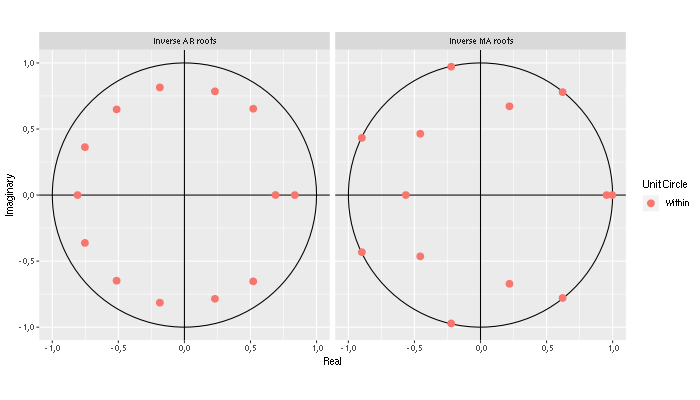

In [20]:
%%R -w 700 -h 400
#Trying Augmeted Dickey-Fuller test to see if the series is stationary:
#$H_0$ is that the model is not stationary
print(tseries::adf.test(mod2$residuals, k=7))
        
#Another way, it shows the roots
print("Modulus of the AR roots:")
print(Mod(1/polyroot(c(1,-mod2$coef[1:6]))))
autoplot(mod2)

Poiché il p-value è basso rifiutiamo l'$H_0$ e possiamo rifiutare l'ipotesi che i residui siano non stazionari. Questo è per il modello AR, mentre per SAR lo abbiamo già visto prima.

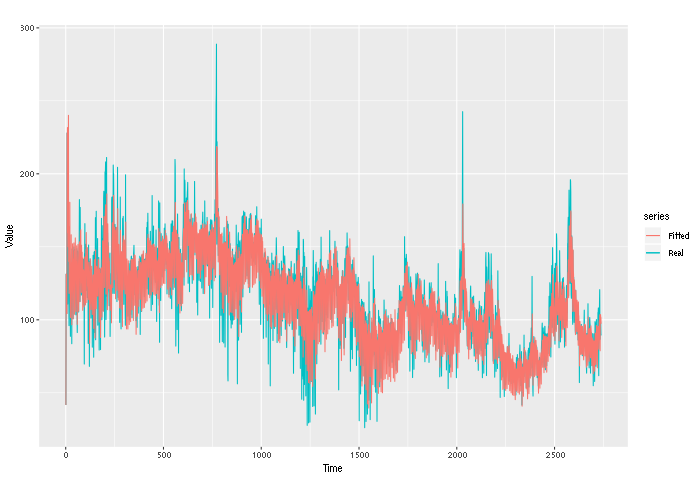

In [21]:
%%R -w 700

autoplot(xts_to_ts(train), series="Real")+
  autolayer(mod2$fitted, series="Fitted")+
  ylab("Value")

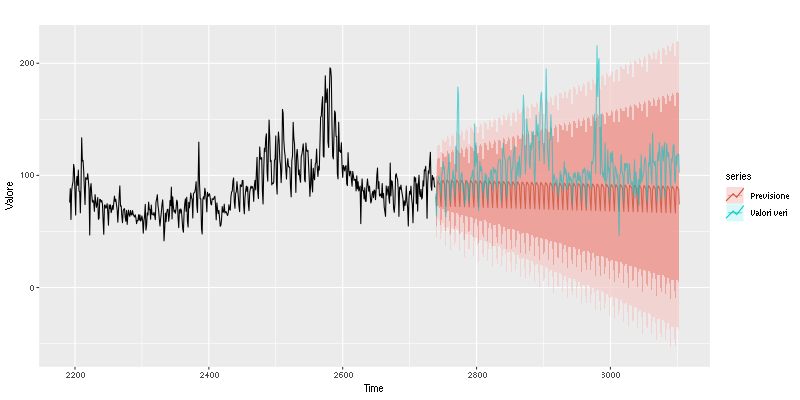

In [22]:
%%R -w 800 -h 400
pred <- forecast(mod2, h=365)

autoplot(xts_to_ts(idata["2016-01-01/2017-06-30"])) +
  autolayer(pred,series="Previsione", alpha=0.7) +
  autolayer(xts_to_ts(validation["2017-07-01/2018-06-30"]), series="Valori veri", alpha=0.6) +
  xlab("Time") +
  ylab("Valore")

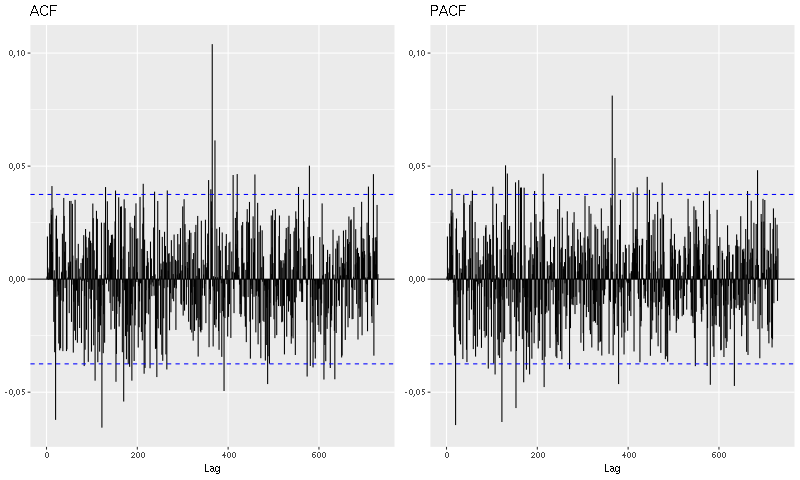

In [23]:
%%R -w 800
ggtsdisplay_2(mod2$residuals, lag.max = 365*2)

Questa serie presenta in realtà una multi-stagionalità come si può vedere nel ACF e PACF sopra, che non può essere risolta con R, per questo si prova ad usare regressori esterni, introducendo una stagionalità annuale e ogni 4 settimane quindi mettiamo regressori dummy mensili e ogni 4 settimane.

In [24]:
%%R
listHolidays()

  [1] "Advent1st"                "Advent2nd"               
  [3] "Advent3rd"                "Advent4th"               
  [5] "AllSaints"                "AllSouls"                
  [7] "Annunciation"             "Ascension"               
  [9] "AshWednesday"             "AssumptionOfMary"        
 [11] "BirthOfVirginMary"        "BoxingDay"               
 [13] "CACanadaDay"              "CACivicProvincialHoliday"
 [15] "CALabourDay"              "CaRemembranceDay"        
 [17] "CAThanksgivingDay"        "CAVictoriaDay"           
 [19] "CelebrationOfHolyCross"   "CHAscension"             
 [21] "CHBerchtoldsDay"          "CHConfederationDay"      
 [23] "CHKnabenschiessen"        "ChristmasDay"            
 [25] "ChristmasEve"             "ChristTheKing"           
 [27] "CHSechselaeuten"          "CorpusChristi"           
 [29] "DEAscension"              "DEChristmasEve"          
 [31] "DECorpusChristi"          "DEGermanUnity"           
 [33] "DENewYearsEve"            "Easter

In [25]:
%%R

#festività natalizie
capodanno <- as.Date(c(unlist(lapply(2010:2019, 
                    function(a) lapply(c("-01-01","-12-31"), 
                                              function (b) paste0(a, b))))))
natale <- as.Date(c(unlist(lapply(2010:2019, 
                    function(a) lapply(paste0("-12-",c(24:26)), 
                                              function (b) paste0(a, b))))))

#Ferragosto
ferragosto <- as.Date(paste0(2010:2019, "-08-15"))

#Pasqua festività
pasqua <- as.Date(c(Easter(2010:2018), EasterMonday(2010:2018)))

#Altre Festività (quasi tutte le più importanti)
altre <- c(as.Date(c(LaborDay(2010:2018), ITAllSaints(2010:2018), 
                   ITLiberationDay(2010:2018), ITImmaculateConception(2010:2018))),
                   as.Date(paste0(2010:2018,"-06-02")), #Festa della Repubblica
                   as.Date(paste0(2010:2018,"-01-06"))) #Befana

In [26]:
%%R
altre

 [1] "2010-05-01" "2011-05-01" "2012-05-01" "2013-05-01" "2014-05-01"
 [6] "2015-05-01" "2016-05-01" "2017-05-01" "2018-05-01" "2010-11-01"
[11] "2011-11-01" "2012-11-01" "2013-11-01" "2014-11-01" "2015-11-01"
[16] "2016-11-01" "2017-11-01" "2018-11-01" "2010-04-25" "2011-04-25"
[21] "2012-04-25" "2013-04-25" "2014-04-25" "2015-04-25" "2016-04-25"
[26] "2017-04-25" "2018-04-25" "2010-12-08" "2011-12-08" "2012-12-08"
[31] "2013-12-08" "2014-12-08" "2015-12-08" "2016-12-08" "2017-12-08"
[36] "2018-12-08" "2010-06-02" "2011-06-02" "2012-06-02" "2013-06-02"
[41] "2014-06-02" "2015-06-02" "2016-06-02" "2017-06-02" "2018-06-02"
[46] "2010-01-06" "2011-01-06" "2012-01-06" "2013-01-06" "2014-01-06"
[51] "2015-01-06" "2016-01-06" "2017-01-06" "2018-01-06"


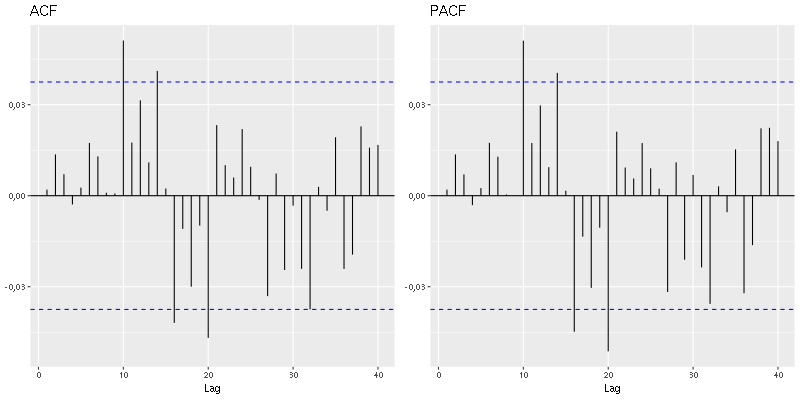

CPU times: user 25min 39s, sys: 40min 2s, total: 1h 5min 42s
Wall time: 8min 27s


In [27]:
%%time
%%R -w 800 -h 400
#create dummy

freq <- outer(1:nrow(df), 1:24)*2*pi/365.25 

cs   <- cos(freq)                   
colnames(cs) <- paste("cos", 1:24)
si   <- sin(freq)                   
colnames(si) <- paste("cos", 1:24)

more_reg <- as.matrix(cbind(cs,si))

data.frame(Data=df$Data) %>%
    mutate(Christmas = as.numeric(Data %in% natale)) %>%
    mutate(NewYear = as.numeric(Data %in% capodanno)) %>%
    mutate(Easter = as.numeric(Data %in% pasqua)) %>%
    mutate(Ferragosto = as.numeric(Data %in% ferragosto)) %>%
    mutate(Other = as.numeric(Data %in% altre)) %>%
    #mutate(WeekDay = data.table::wday(df$Data)) %>%
    #mutate(WeekDay = paste0("W",data.table::wday(df$Data)), ind=1) %>% 
    #spread(WeekDay, ind, fill = 0) %>% #nice way to do one-hot encoding
    select(-starts_with("Data")) %>% 
    cbind(more_reg) %>% 
    as.matrix() -> more_reg

#eliminiamo la prima e l'ultima colonna, per evitare multicollinearità
xreg <- more_reg 

mod1_reg <- Arima(train, c(6,1,6), list(order=c(1,1,1), period=7), 
              xreg=xreg[1:(length(train)),], include.constant = TRUE, lambda = "auto")

ggtsdisplay_2(mod1_reg$residuals, lag.max = 40)

In [28]:
%%R
print(paste0("MAPE on train ", mean(abs(mod1_reg$fitted-as.numeric(train))/as.numeric(train)))) #train_perf
print(tseries::adf.test(mod1_reg$residuals)) #sono RW

[1] "MAPE on train0,0909492083317021"

	Augmented Dickey-Fuller Test

data:  mod1_reg$residuals
Dickey-Fuller = -12,503, Lag order = 13, p-value = 0,01
alternative hypothesis: stationary



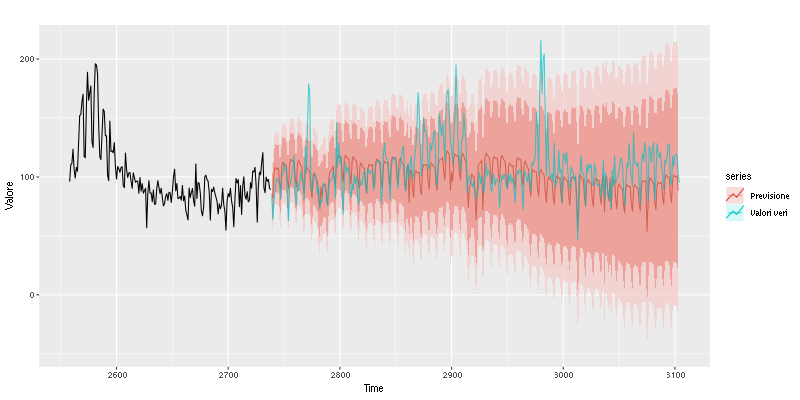

In [29]:
%%R -w 800 -h 400
pred_reg <- forecast(mod1_reg, h=365, 
              xreg=xreg[(length(train)+1):(length(train)+365),])
autoplot(pred_reg)

autoplot(xts_to_ts(train["2017-01-01/2017-06-30"])) +
  autolayer(pred_reg,series="Previsione",alpha=0.7) +
  autolayer(xts_to_ts(validation["2017-07-01/2018-07-01"]), series="Valori veri", alpha=0.7)+
  #autolayer(forecast(train, h=365)$mean, alpha=0.5, series="Forecast(Default)") +
  ylab("Valore")

In [30]:
%%time
%%R

#i=0
temp_forecast <- forecast(mod1_reg, h=365, xreg=xreg[(length(train)):(length(train)+364),])
tot_score_arima <- mean(abs(temp_forecast$mean - validation[1:365])/validation[1:365])

for (i in 1:(length(validation) - 365)){
    temp_mod <- Arima(c(train[i:length(train)],validation[1:i]), 
                      model=mod1_reg, xreg=xreg[i:(length(train)+i),])
    temp_forecast <- forecast(temp_mod, h=365, xreg=xreg[(length(train)+i+1):(length(train)+i+364+1),])$mean
    score <- mean(abs(temp_forecast - validation[(i+1):(i+365)])/validation[(i+1):(i+365)])
    tot_score_arima <- tot_score_arima + score
}

print(paste0("ARIMA average MAPE:", tot_score_arima/(length(validation) - 365 + 1)))
arima_score <- tot_score_arima/(length(validation) - 365 + 1)*100

[1] "ARIMA average MAPE:0,178852611920941"


CPU times: user 1min 2s, sys: 2min 20s, total: 3min 22s
Wall time: 26.5 s


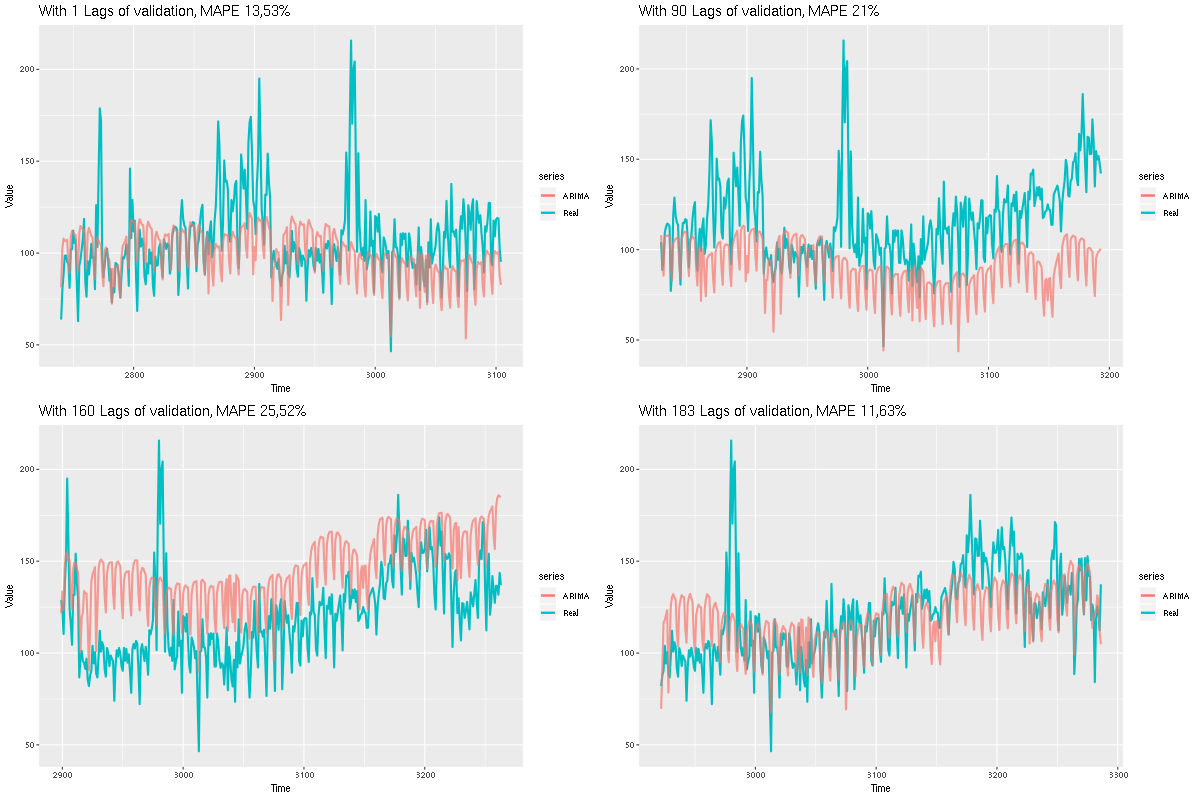

In [31]:
%%R -w 1200 -h 800
i=1
temp_mod <- Arima(c(train[i:length(train)],validation[1:i]), 
                      model=mod1_reg, xreg=xreg[i:(length(train)+i),])
temp_forecast <- forecast(temp_mod, h=365, 
                          xreg=xreg[(length(train)+i+1):(length(train)+i+364+1),])$mean
valid <- validation[(i+1):(i+365)]
mae <- mean(abs(temp_forecast - valid)/valid)

p1 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Real",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="ARIMA", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%"))
        
i=90

temp_mod <- Arima(c(train[i:length(train)],validation[1:i]), 
                      model=mod1_reg, xreg=xreg[i:(length(train)+i),])
temp_forecast <- forecast(temp_mod, h=365, 
                          xreg=xreg[(length(train)+i+1):(length(train)+i+364+1),])$mean
valid <- validation[(i+1):(i+365)]
mae <- mean(abs(temp_forecast - valid)/valid)

p2 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Real",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="ARIMA", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%"))

i=160

temp_mod <- Arima(c(train[i:length(train)],validation[1:i]), 
                      model=mod1_reg, xreg=xreg[i:(length(train)+i),])
temp_forecast <- forecast(temp_mod, h=365, 
                          xreg=xreg[(length(train)+i+1):(length(train)+i+364+1),])$mean
valid <- validation[(i+1):(i+365)]
mae <- mean(abs(temp_forecast - valid)/valid)

p3 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Real",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="ARIMA", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%"))
        
i=183
temp_mod <- Arima(c(train[i:length(train)],validation[1:i]), 
                      model=mod1_reg, xreg=xreg[i:(length(train)+i),])
temp_forecast <- forecast(temp_mod, h=365, 
                          xreg=xreg[(length(train)+i+1):(length(train)+i+364+1),])$mean
valid <- validation[(i+1):(i+365)]
mae <- mean(abs(temp_forecast - valid)/valid)

p4 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Real",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="ARIMA", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%"))

gridExtra::grid.arrange(p1, p2, p3, p4, nrow = 2)

# UCM with R

In [32]:
%%time
%%R

ytrain <- as.numeric(train)
#ytrain[(length(ytrain)+1):(length(ytrain)+365)] <- NA
#ytrain <- xts(ytrain, order.by=df$Data)

data.frame(Data=df$Data) %>%
    mutate(Christmas = as.numeric(as.numeric(Data %in% natale))) %>%
    mutate(Ferragosto = as.numeric(as.numeric(Data %in% ferragosto))) %>%
    mutate(Easter = as.numeric(as.numeric(Data %in% pasqua))) %>%
    mutate(Other = as.numeric(Data %in% altre)) %>%
    select(-starts_with("Data"))  -> more_reg

#Si comporta peggio se si usano i regressori con i quali XARIMA funzionava meglio!?
ucm_mod1 <- SSModel(ytrain ~  Christmas + Ferragosto + Easter +
                      Other +
                      SSMtrend(2, list(NA,NA)) +
                      SSMseasonal(7, NA, "dummy") +
                      SSMseasonal(365, NA, "trig",
                                  harmonics = 1:24),
                H = NA, data=more_reg[1:length(ytrain),])

vary <- var(ytrain, na.rm = TRUE)
ucm_mod1$P1inf <- ucm_mod1$P1inf * 0
ucm_mod1$a1[1] <- mean(ytrain, na.rm = TRUE)
diag(ucm_mod1$P1) <- vary



# Initial values for the variances we have to estimate
init <- numeric(5)
init[1] <- log(vary/10) # log-var(dist.rw)
init[2] <- log(vary/10)
init[3] <- log(vary/100)# log-var(dist.seas)
init[4] <- log(vary/100)# log-var(trig.seas)
init[5] <- log(vary/10) # log-var(err.oss.)

# Estimate
update_fun <- function(pars, model){
    model$Q[1, 1, 1] <- exp(pars[1])
    model$Q[2, 2, 1] <- exp(pars[2])
    model$Q[3, 3, 1] <- exp(pars[3])
    diag(model$Q[4:51, 4:51, 1]) <- exp(pars[4])
    model$H[1, 1, 1] <- exp(pars[5])
    model
}

fit1 <- fitSSM(ucm_mod1, init, update_fun)
print(fit1$optim.out$convergence)

[1] 0


CPU times: user 1min 55s, sys: 2min 24s, total: 4min 19s
Wall time: 37.3 s


In [33]:
%%time
%%R

### i=0
data <- c(rep(NA, 365))
temp_mod <- SSModel(data ~  Christmas + Ferragosto + Easter +
                      Other +
                      SSMtrend(2, list(fit1$model$Q[1,1,1],fit1$model$Q[2,2,1])) +
                      SSMseasonal(7, fit1$model$Q[3,3,1], "dummy") +
                      SSMseasonal(365, fit1$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                    H = fit1$model$H, 
                    data=more_reg[(length(train)+1):(length(train)+365),])
ucm_pred <- predict(fit1$model, newdata=temp_mod, n.ahead=365)[1:365]
valid <- as.numeric(validation)[1:365]

tot_score_ucm <- mean(abs(ucm_pred - valid)/valid)

for (i in 1:(length(validation) - 365)){
    data <- c(as.numeric(validation[1:i]), rep(NA, 365))
    temp_mod <- SSModel(data ~  Christmas + Ferragosto + Easter +
                      Other +
                      SSMtrend(2, list(fit1$model$Q[1,1,1],fit1$model$Q[2,2,1])) +
                      SSMseasonal(7, fit1$model$Q[3,3,1], "dummy") +
                      SSMseasonal(365, fit1$model$Q[4, 4, 1], "trig",
                                  harmonics = 1:24),
                    H = fit1$model$H, 
                        data=more_reg[(length(train)+1):(length(train)+i+365),])
    #ucm_pred <- predict(fit1$model, newdata=temp_mod, n.ahead=365)[i:(i+365)]
    ucm_pred <- predict(fit1$model, newdata=temp_mod, n.ahead=365)[(i+1):(i+365)]
    valid <- as.numeric(validation)[(i+1):(i+365)]
    score <- mean(abs(ucm_pred - valid)/valid)
    tot_score_ucm <- tot_score_ucm + score
}
print(tot_score_ucm/(length(validation) - 365 + 1))

[1] 0,192128


CPU times: user 7min 55s, sys: 8min 34s, total: 16min 29s
Wall time: 3min 38s


In [34]:
%%time
%%R
ucm_mod2 <- SSModel(ytrain ~ SSMtrend(2, list(NA,NA)) +
                      SSMseasonal(7, NA, "dummy") +
                      SSMseasonal(365, NA, "trig",
                                  harmonics = 1:24),
                H = NA)

vary <- var(ytrain, na.rm = TRUE)
ucm_mod2$P1inf <- ucm_mod2$P1inf * 0
ucm_mod2$a1[1] <- mean(ytrain, na.rm = TRUE)
diag(ucm_mod2$P1) <- vary



# Initial values for the variances we have to estimate
init <- numeric(5)
init[1] <- log(vary/10) # log-var(dist.rw)
init[2] <- log(vary/10)
init[3] <- log(vary/100)# log-var(dist.seas)
init[4] <- log(vary/100)# log-var(trig.seas)
init[5] <- log(vary/10) # log-var(err.oss.)

# Estimate
update_fun <- function(pars, model){
    model$Q[1, 1, 1] <- exp(pars[1])
    model$Q[2, 2, 1] <- exp(pars[2])
    model$Q[3, 3, 1] <- exp(pars[3])
    diag(model$Q[4:51, 4:51, 1]) <- exp(pars[4])
    model$H[1, 1, 1] <- exp(pars[5])
    model
}

fit2 <- fitSSM(ucm_mod2, init, update_fun)
print(fit2$optim.out$convergence)

[1] 0


CPU times: user 1min 47s, sys: 2min 13s, total: 4min
Wall time: 34.5 s


In [35]:
%%time
%%R

data <- c(rep(NA, 365))
temp_mod <- SSModel(data ~  SSMtrend(2, list(fit2$model$Q[1,1,1],fit2$model$Q[2,2,1])) +
                      SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                      SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                    H = fit2$model$H)
ucm_pred <- predict(fit2$model, newdata=temp_mod)[1:365]
valid <- as.numeric(validation)[1:365]

tot_score_ucm <- mean(abs(ucm_pred - valid)/valid)

for (i in 1:(length(validation) - 365)){
    data <- c(as.numeric(validation[1:i]), rep(NA, 365))
    temp_mod <- SSModel(data ~ SSMtrend(2, list(fit2$model$Q[1,1,1],fit2$model$Q[2,2,1])) +
                      SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                      SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                                  harmonics = 1:24),
                    H = fit2$model$H)
    ucm_pred <- predict(fit2$model, newdata=temp_mod)[(i+1):(i+365)]
    valid <- as.numeric(validation)[(i+1):(i+365)]
    score <- mean(abs(ucm_pred - valid)/valid)
    tot_score_ucm <- tot_score_ucm + score
}
print(paste0("UCM average MAPE:", tot_score_ucm/(length(validation) - 365 + 1)))
ucm_score <- tot_score_ucm/(length(validation) - 365 + 1)*100

[1] "UCM average MAPE:0,180642440673268"


CPU times: user 6min 45s, sys: 7min 31s, total: 14min 16s
Wall time: 2min 58s


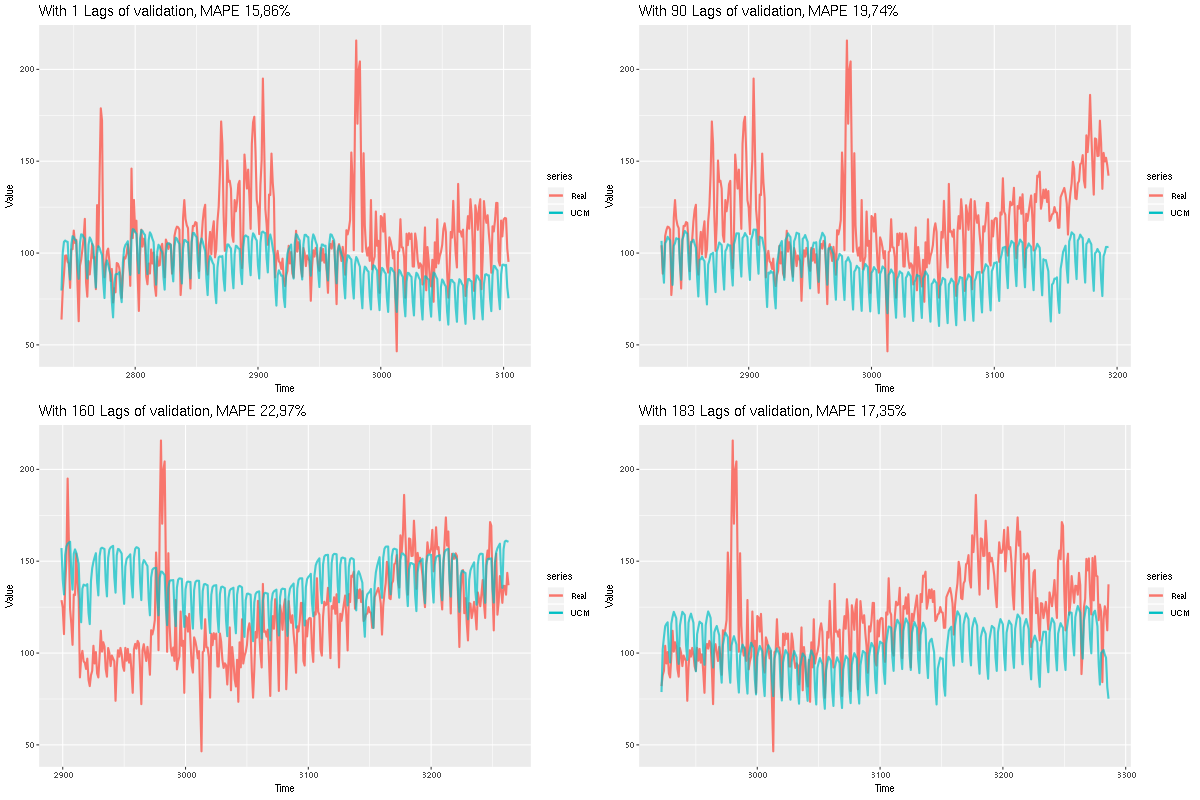

In [36]:
%%R -w 1200 -h 800
i=1
data <- c(as.numeric(validation[1:i]), rep(NA, 365))
temp_mod <- SSModel(data ~ SSMtrend(2, list(fit2$model$Q[1,1,1],fit2$model$Q[2,2,1])) +
                  SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                  SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                H = fit2$model$H)
temp_forecast <- predict(fit2$model, newdata=temp_mod)[(i+1):(i+365)]
valid <- validation[(i+1):(i+365)]
mae <- mean(abs(temp_forecast - valid)/valid)

p1 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Real",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="UCM", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%"))
        
i=90

data <- c(as.numeric(validation[1:i]), rep(NA, 365))
temp_mod <- SSModel(data ~ SSMtrend(2, list(fit2$model$Q[1,1,1],fit2$model$Q[2,2,1])) +
                  SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                  SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                H = fit2$model$H)
temp_forecast <- predict(fit2$model, newdata=temp_mod)[(i+1):(i+365)]
valid <- validation[(i+1):(i+365)]
mae <- mean(abs(temp_forecast - valid)/valid)

p2 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Real",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="UCM", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%"))

i=160

data <- c(as.numeric(validation[1:i]), rep(NA, 365))
temp_mod <- SSModel(data ~ SSMtrend(2, list(fit2$model$Q[1,1,1],fit2$model$Q[2,2,1])) +
                  SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                  SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                H = fit2$model$H)
temp_forecast <- predict(fit2$model, newdata=temp_mod)[(i+1):(i+365)]
valid <- validation[(i+1):(i+365)]
mae <- mean(abs(temp_forecast - valid)/valid)

p3 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Real",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="UCM", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%"))
        
i=183
data <- c(as.numeric(validation[1:i]), rep(NA, 365))
temp_mod <- SSModel(data ~ SSMtrend(2, list(fit2$model$Q[1,1,1],fit2$model$Q[2,2,1])) +
                  SSMseasonal(7, fit2$model$Q[3,3,1], "dummy") +
                  SSMseasonal(365, fit2$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                H = fit2$model$H)
temp_forecast <- predict(fit2$model, newdata=temp_mod)[(i+1):(i+365)]
valid <- validation[(i+1):(i+365)]
mae <- mean(abs(temp_forecast - valid)/valid)

p4 <- ggplot() +
        autolayer(xts_to_ts(valid), series="Real",size=1) +
        autolayer(ts(temp_forecast, start=start(xts_to_ts(valid)),
                    frequency=frequency(xts_to_ts(valid))),
                  series="UCM", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value") + ggtitle(paste0("With ", i, " Lags of validation, MAPE ",round(mae,4)*100,"%"))

gridExtra::grid.arrange(p1, p2, p3, p4, nrow = 2)

[1] "MAPE on train0,109805024539575"


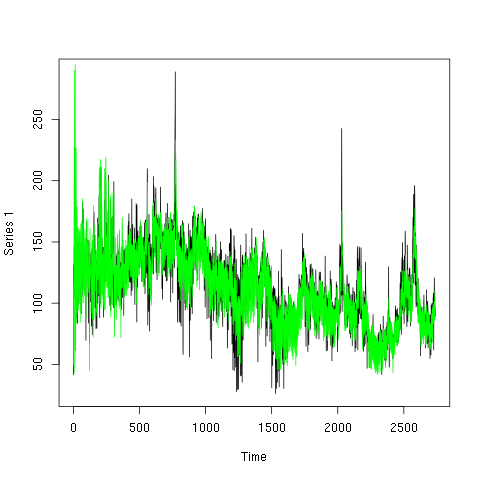

In [37]:
%%R
#in training:

smo1 <- KFS(fit2$model, filtering = "mean", smoothing = NULL)

plot(xts_to_ts(train))
lines(smo1$m, col="green")
print(paste0("MAPE on train ",mean(abs(xts_to_ts(train) - smo1$m)/xts_to_ts(train))))

# LSTM with Python

In [38]:
%%capture
!pip install parameter-sherpa

In [39]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import time

%matplotlib inline

In [40]:
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, regularizers

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import sherpa #AutoML

from sklearn.preprocessing import MinMaxScaler, StandardScaler

print("Tesorflow Version:", tf.__version__)
print("Keras Version:",tf.keras.__version__)

Tesorflow Version: 2.0.0
Keras Version: 2.2.4-tf


In [41]:
path = "data/"
#path = "/content/drive/My Drive/ts_proj/"

In [42]:
df = pd.read_csv(path + "time_series_dataset.csv", sep=";", decimal=".")
df.Data = pd.to_datetime(df.Data)
df.head()

,Data,value
0,2010-01-01,41.651044
1,2010-01-02,131.286604
2,2010-01-03,117.388117
3,2010-01-04,116.461280
4,2010-01-05,123.823765


In [43]:
train = df[df.Data <= pd.to_datetime("2017-06-30")]
val  = df[df.Data  > pd.to_datetime("2017-06-30")]

x_scaler = StandardScaler().\
            fit(np.array(train.value).reshape(-1,1))

train_scaled = x_scaler.transform(np.array(train.value).reshape(-1,1))
val_scaled = x_scaler.transform(np.array(val.value).reshape(-1,1))

data_scaled = np.concatenate((train_scaled, val_scaled))

In [44]:
def sliding_windows(data, seq_length, pred_lenght):
    x = []
    y = []

    for i in range(len(data)-seq_length-pred_lenght-1):
        x.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length:i+seq_length+pred_lenght])

    return np.array(x),np.array(y)

In [45]:
INPUT_SIZE = 365*2 #2 years
OUTPUT_SIZE = 365


slides = sliding_windows(data_scaled, 
                         INPUT_SIZE ,OUTPUT_SIZE)

X = slides[0].reshape(slides[0].shape[0],
                            slides[0].shape[1],
                           1)
y = slides[1]

X_train, X_val = X[:-184], X[-184:]
y_train, y_val = y[:-184], y[-184:]

In [46]:
print(X_train.shape)
print(X_val.shape)

(2007, 730, 1)
(184, 730, 1)


In [47]:
print(y_train.shape)
print(y_val.shape)

(2007, 365, 1)
(184, 365, 1)


### First Architecture

In [48]:
#The number of epoch could also be an hyperparameter
# but to reduce the computation stress it has been 
# fixed to be 100, (on approximately 2000 data) it is sufficient,
# otherwise it will start overfitting a lot! 
def get_model_score(params, epochs=100, verbose=0):
    early = EarlyStopping(monitor='val_loss', patience=50, verbose=0)
    lr_decay = ReduceLROnPlateau(monitor='val_loss', 
                             patience=3, verbose=0, 
                             factor=0.5, min_lr=1e-5)
    initial = Input(shape=(INPUT_SIZE,1))

    x = LSTM(int(params['lstm_unit']), activation='tanh', 
           return_sequences=False,
           kernel_regularizer=regularizers.l1(0.001),
           activity_regularizer=regularizers.l1(0.001))(initial)

    x = Dense(int(params["hidden_unit1"]), activation='relu')(x)
    x = Dense(int(params["hidden_unit2"]), activation='relu')(x)

    out = Dense(OUTPUT_SIZE, activation='linear')(x)

    model = Model(initial, out)

    model.compile(loss='mse',
                optimizer=optimizers.RMSprop(learning_rate=params["lr_init"]), 
                metrics=['mae'])

    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
            batch_size=int(params["batch_size"]), epochs=epochs, 
            callbacks=[lr_decay, early],
            verbose=verbose)
    return model, model.evaluate(X_val, y_val)[0], hist

In [ ]:
parameters = [sherpa.Discrete('lstm_unit',[20,250]),
              sherpa.Discrete('hidden_unit1',[256,512]),
              sherpa.Discrete('hidden_unit2',[256,512]),
              sherpa.Continuous('lr_init', [0.0005, 0.005]),
              sherpa.Ordinal(name='batch_size', range=[64, 128, 256])]
alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [ ]:
best_score = 999999

for trial in study:
    start_time = time.time()
    
    model, score, hist = get_model_score(trial.parameters)
    
    if np.isnan(score):
        score = 999999
        print("Model Crashed or 'NaNed'")
      
    if score != 999999:
        study.add_observation(trial, iteration=1, objective=score)
        if score < best_score:
            model.save(path + "best_model.h5")
            best_model   = model
            best_score   = score
            best_history = hist
    else:
        del model #free RAM
    study.finalize(trial)
    if(trial.id % 10 == 0 or trial.id == 1):
        print("Trial:",trial.id, "|| Best Score: ", best_score, " || Took ",str(time.time()-start_time), "Seconds")
    study.results.to_csv(path + "AutoML.csv")

184/184 [==============================] - 0s 552us/sample - loss: 0.7985 - mae: 0.6752


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Trial: 1 || Best Score:  0.7985449822052665  || Took  64.06530857086182 Seconds
184/184 [==============================] - 0s 561us/sample - loss: 0.8631 - mae: 0.7086


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 563us/sample - loss: 0.9529 - mae: 0.7316


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 640us/sample - loss: 0.8917 - mae: 0.7130


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 510us/sample - loss: 1.0050 - mae: 0.7494


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 564us/sample - loss: 0.9254 - mae: 0.7278


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 10 || Best Score:  0.7985449822052665  || Took  58.2217857837677 Seconds
184/184 [==============================] - 0s 583us/sample - loss: 0.7517 - mae: 0.6583


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 520us/sample - loss: 0.9429 - mae: 0.7324


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 503us/sample - loss: 0.9519 - mae: 0.7350


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 675us/sample - loss: 0.8213 - mae: 0.6674


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 450us/sample - loss: 0.9350 - mae: 0.7199


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 387us/sample - loss: 0.8035 - mae: 0.6863


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 514us/sample - loss: 0.9875 - mae: 0.7437


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 475us/sample - loss: 0.8568 - mae: 0.7043


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 597us/sample - loss: 0.7900 - mae: 0.6818


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 506us/sample - loss: 0.9220 - mae: 0.7306


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 20 || Best Score:  0.7516967628313147  || Took  52.837143659591675 Seconds
184/184 [==============================] - 0s 468us/sample - loss: 0.8279 - mae: 0.6863


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 442us/sample - loss: 0.9667 - mae: 0.7394


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 607us/sample - loss: 0.8399 - mae: 0.7006


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 491us/sample - loss: 0.9667 - mae: 0.7397


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 632us/sample - loss: 0.9613 - mae: 0.7366


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 560us/sample - loss: 0.7937 - mae: 0.6691


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 458us/sample - loss: 0.8401 - mae: 0.6961


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 375us/sample - loss: 0.9319 - mae: 0.7384


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 478us/sample - loss: 0.6352 - mae: 0.5742


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 591us/sample - loss: 0.9484 - mae: 0.7594


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 30 || Best Score:  0.6351510182670925  || Took  74.7838077545166 Seconds
184/184 [==============================] - 0s 448us/sample - loss: 0.9646 - mae: 0.7375


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 539us/sample - loss: 0.9391 - mae: 0.7270


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 512us/sample - loss: 0.9733 - mae: 0.7409


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 519us/sample - loss: 0.9858 - mae: 0.7429


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 368us/sample - loss: 0.9363 - mae: 0.7252


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 511us/sample - loss: 0.9666 - mae: 0.7483


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 573us/sample - loss: 0.8599 - mae: 0.7145


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 382us/sample - loss: 0.9268 - mae: 0.7363


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 666us/sample - loss: 0.9125 - mae: 0.6745


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 422us/sample - loss: 0.9388 - mae: 0.7297


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 40 || Best Score:  0.6351510182670925  || Took  22.050540447235107 Seconds
184/184 [==============================] - 0s 627us/sample - loss: 0.9924 - mae: 0.7554


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 506us/sample - loss: 0.8060 - mae: 0.6901


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 513us/sample - loss: 0.8393 - mae: 0.6992


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 397us/sample - loss: 0.9185 - mae: 0.7157


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 535us/sample - loss: 0.8685 - mae: 0.7001


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 410us/sample - loss: 0.9500 - mae: 0.7308


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 510us/sample - loss: 0.8114 - mae: 0.6916


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 714us/sample - loss: 0.9845 - mae: 0.7438


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 529us/sample - loss: 0.9708 - mae: 0.7406


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 496us/sample - loss: 0.6725 - mae: 0.6064


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 50 || Best Score:  0.6351510182670925  || Took  89.36493945121765 Seconds
184/184 [==============================] - 0s 449us/sample - loss: 0.9321 - mae: 0.7311


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 496us/sample - loss: 0.8532 - mae: 0.6948


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 459us/sample - loss: 0.6994 - mae: 0.6324


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 715us/sample - loss: 0.9759 - mae: 0.7337


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 738us/sample - loss: 0.9884 - mae: 0.7333


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 525us/sample - loss: 0.9631 - mae: 0.7361


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 626us/sample - loss: 0.8590 - mae: 0.6929


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 525us/sample - loss: 0.9042 - mae: 0.7157


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 531us/sample - loss: 0.8642 - mae: 0.7160


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 469us/sample - loss: 0.8525 - mae: 0.7064


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 60 || Best Score:  0.6351510182670925  || Took  48.54144477844238 Seconds
184/184 [==============================] - 0s 471us/sample - loss: 0.9283 - mae: 0.7236


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 451us/sample - loss: 0.9237 - mae: 0.7346


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 543us/sample - loss: 0.9551 - mae: 0.7331


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 522us/sample - loss: 0.9267 - mae: 0.7135


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 481us/sample - loss: 0.9773 - mae: 0.7429


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 421us/sample - loss: 0.7915 - mae: 0.6705


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 366us/sample - loss: 0.9819 - mae: 0.7629


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 489us/sample - loss: 0.9625 - mae: 0.7425


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 627us/sample - loss: 0.9608 - mae: 0.7380


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 428us/sample - loss: 0.9178 - mae: 0.7214


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 70 || Best Score:  0.6351510182670925  || Took  21.66011118888855 Seconds
184/184 [==============================] - 0s 651us/sample - loss: 1.0295 - mae: 0.7583


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 423us/sample - loss: 0.9284 - mae: 0.7204


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 471us/sample - loss: 0.9930 - mae: 0.7437


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 617us/sample - loss: 0.8633 - mae: 0.7032


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 509us/sample - loss: 0.8720 - mae: 0.7127


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 474us/sample - loss: 0.9206 - mae: 0.7105


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 367us/sample - loss: 0.9265 - mae: 0.7320


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 412us/sample - loss: 0.9214 - mae: 0.7181


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 508us/sample - loss: 0.6448 - mae: 0.5901


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 512us/sample - loss: 0.8714 - mae: 0.7084


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 80 || Best Score:  0.6351510182670925  || Took  52.791744232177734 Seconds
184/184 [==============================] - 0s 420us/sample - loss: 0.9706 - mae: 0.7580


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 456us/sample - loss: 0.7984 - mae: 0.6841


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 455us/sample - loss: 0.8019 - mae: 0.6757


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 382us/sample - loss: 0.9352 - mae: 0.7409


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 571us/sample - loss: 0.9640 - mae: 0.7385


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 550us/sample - loss: 0.9836 - mae: 0.7424


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 381us/sample - loss: 0.8909 - mae: 0.7193


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 597us/sample - loss: 0.9169 - mae: 0.6983


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 594us/sample - loss: 0.9705 - mae: 0.7375


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 375us/sample - loss: 0.9091 - mae: 0.7154


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 90 || Best Score:  0.6351510182670925  || Took  22.75887703895569 Seconds
184/184 [==============================] - 0s 548us/sample - loss: 0.9391 - mae: 0.7281


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 532us/sample - loss: 1.0170 - mae: 0.7488


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 487us/sample - loss: 0.6775 - mae: 0.6208


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 506us/sample - loss: 0.9563 - mae: 0.7344


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 499us/sample - loss: 0.8125 - mae: 0.6993


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 517us/sample - loss: 0.8097 - mae: 0.6890


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 509us/sample - loss: 0.8592 - mae: 0.7100


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 569us/sample - loss: 0.8766 - mae: 0.7163


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 554us/sample - loss: 0.7411 - mae: 0.6588


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 479us/sample - loss: 0.9640 - mae: 0.7403
Trial: 100 || Best Score:  0.6351510182670925  || Took  28.6276273727417 Seconds


In [49]:
best_model = tf.keras.models.load_model(path + "best_model.h5")
results = pd.read_csv(path + "AutoML.csv")
results = results[results["Status"]=="COMPLETED"]

In [50]:
results.head()

,Unnamed: 0,Trial-ID,Status,Iteration,batch_size,hidden_unit1,hidden_unit2,lr_init,lstm_unit,Objective
1,1,1,COMPLETED,1,128.0,376.0,411.0,0.000980,204.0,0.798545
3,3,2,COMPLETED,1,64.0,372.0,280.0,0.002586,60.0,0.945296
5,5,3,COMPLETED,1,128.0,312.0,268.0,0.001152,66.0,0.942746
7,7,4,COMPLETED,1,64.0,314.0,508.0,0.002527,173.0,0.840541
9,9,5,COMPLETED,1,128.0,400.0,349.0,0.002557,204.0,0.879348


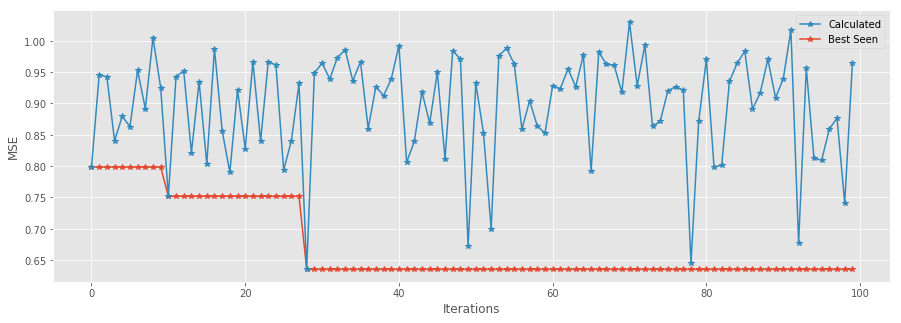

In [51]:
plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
actual, = plt.plot(np.array(results.Objective),'*-')

plt.legend([actual, best],
           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

In [52]:
best_model.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 730, 1)]          0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 97)                38412     
_________________________________________________________________
dense_84 (Dense)             (None, 400)               39200     
_________________________________________________________________
dense_85 (Dense)             (None, 434)               174034    
_________________________________________________________________
dense_86 (Dense)             (None, 365)               158775    
Total params: 410,421
Trainable params: 410,421
Non-trainable params: 0
_________________________________________________________________


In [53]:
best_model.evaluate(X_train, y_train)
best_model.evaluate(X_val, y_val)

184/184 [==============================] - 1s 3ms/sample - loss: 0.6352 - mean_absolute_error: 0.5742


[0.635151163391445, 0.57422584]

In [54]:
pred = best_model.predict(X_val)
valid = x_scaler.inverse_transform(y_val).reshape(y_val.shape[0],y_val.shape[1])
pred = x_scaler.inverse_transform(pred)

print("MAPE:",np.mean(list(map(np.mean,np.abs(pred - valid)/np.abs(valid)))))

MAPE: 0.14535552741659702


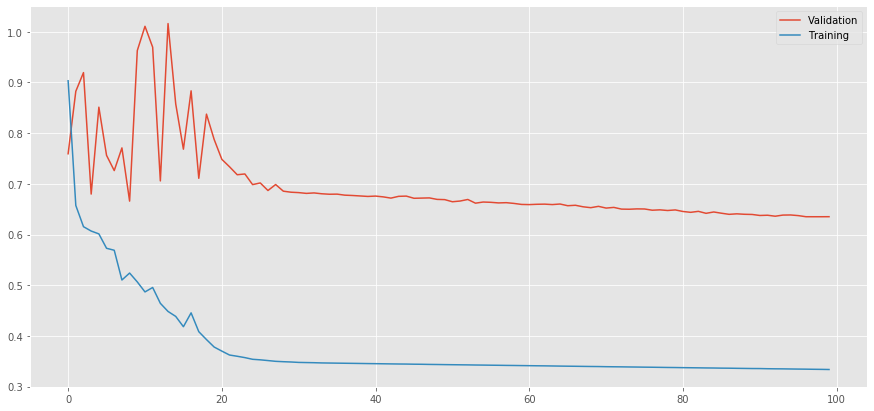

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(best_history.history['val_loss'])
plt.plot(best_history.history['loss'])
plt.legend(['Validation','Training'])

plt.show()

### Second Architecture


In [ ]:
#The number of epoch could also be an hyperparameter
# but to reduce the computation stress it has been 
# fixed to be 100, (on approximately 2000 data) it is sufficient,
# otherwise it will start overfitting a lot! 
def get_model_score(params, epochs=100, verbose=0):
    early = EarlyStopping(monitor='val_loss', patience=50, verbose=0)
    lr_decay = ReduceLROnPlateau(monitor='val_loss', 
                             patience=3, verbose=0, 
                             factor=0.5, min_lr=1e-5)
    initial = Input(shape=(INPUT_SIZE,1))

    x = LSTM(int(params['lstm_unit']), activation='tanh', 
           return_sequences=False,
           kernel_regularizer=regularizers.l1(0.001),
           activity_regularizer=regularizers.l1(0.001))(initial)

    x = Dense(int(params["hidden_unit1"]), activation='relu')(x)
    x = Dense(int(params["hidden_unit2"]), activation='relu')(x)
    x = Dense(int(params["hidden_unit3"]), activation='relu')(x)

    out = Dense(OUTPUT_SIZE, activation='linear')(x)

    model = Model(initial, out)

    model.compile(loss='mse',
                optimizer=optimizers.RMSprop(learning_rate=params["lr_init"]), 
                metrics=['mae'])

    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
            batch_size=int(params["batch_size"]), epochs=epochs, 
            callbacks=[lr_decay, early],
            verbose=verbose)
    return model, model.evaluate(X_val, y_val)[0], hist


parameters = [sherpa.Discrete('lstm_unit',[20,250]),
              sherpa.Discrete('hidden_unit1',[256,512]),
              sherpa.Discrete('hidden_unit2',[256,512]),
              sherpa.Discrete('hidden_unit3',[256,512]),
              sherpa.Continuous('lr_init', [0.0005, 0.005]),
              sherpa.Ordinal(name='batch_size', range=[64, 128, 256])]
alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

best_score = 999999

for trial in study:
    start_time = time.time()
    
    model, score, hist = get_model_score(trial.parameters)
    
    if np.isnan(score):
        score = 999999
        print("Model Crashed or 'NaNed'")
      
    if score != 999999:
        study.add_observation(trial, iteration=1, objective=score)
        if score < best_score:
            model.save(path + "best_model_2.h5")
            best_model   = model
            best_score   = score
            best_history = hist
    else:
        del model #free RAM
    study.finalize(trial)
    if(trial.id % 10 == 0 or trial.id == 1):
        print("Trial:",trial.id, "|| Best Score: ", best_score, " || Took ",str(time.time()-start_time), "Seconds")
    study.results.to_csv(path + "AutoML_2.csv")

184/184 [==============================] - 0s 437us/sample - loss: 0.8537 - mae: 0.6882
Trial: 1 || Best Score:  0.8536763217138208  || Took  15.384631395339966 Seconds
184/184 [==============================] - 0s 709us/sample - loss: 0.9656 - mae: 0.7499


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 480us/sample - loss: 0.9296 - mae: 0.7209


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 479us/sample - loss: 0.9318 - mae: 0.7350


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 423us/sample - loss: 0.9751 - mae: 0.7439


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 10 || Best Score:  0.842869740465413  || Took  25.60354471206665 Seconds
184/184 [==============================] - 0s 487us/sample - loss: 0.8328 - mae: 0.6978


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 458us/sample - loss: 0.7753 - mae: 0.6647


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 542us/sample - loss: 0.9053 - mae: 0.7235


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 594us/sample - loss: 0.9856 - mae: 0.7461


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 571us/sample - loss: 1.0102 - mae: 0.7473


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 382us/sample - loss: 0.9255 - mae: 0.7248


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 541us/sample - loss: 0.9703 - mae: 0.7442


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 498us/sample - loss: 0.8854 - mae: 0.7130


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 416us/sample - loss: 0.9867 - mae: 0.7487


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 540us/sample - loss: 0.9455 - mae: 0.7300


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 20 || Best Score:  0.7753389607305112  || Took  40.97932314872742 Seconds
184/184 [==============================] - 0s 422us/sample - loss: 0.9749 - mae: 0.7644


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 455us/sample - loss: 0.7426 - mae: 0.6483


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 464us/sample - loss: 0.9749 - mae: 0.7391


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 657us/sample - loss: 0.8803 - mae: 0.7127


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 371us/sample - loss: 0.9750 - mae: 0.7541


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 343us/sample - loss: 1.0157 - mae: 0.7754


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 407us/sample - loss: 1.0136 - mae: 0.7758


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 522us/sample - loss: 0.9324 - mae: 0.7364


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 523us/sample - loss: 0.9366 - mae: 0.7369


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 509us/sample - loss: 0.7260 - mae: 0.6503


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 30 || Best Score:  0.7260099856749825  || Took  167.33863186836243 Seconds
184/184 [==============================] - 0s 540us/sample - loss: 0.9573 - mae: 0.7449


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 429us/sample - loss: 0.9667 - mae: 0.7469


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 426us/sample - loss: 0.9629 - mae: 0.7494


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 470us/sample - loss: 0.8372 - mae: 0.7020


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 446us/sample - loss: 0.8848 - mae: 0.7196


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 649us/sample - loss: 0.9665 - mae: 0.7299


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 444us/sample - loss: 0.8100 - mae: 0.6846


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 472us/sample - loss: 1.0379 - mae: 0.7581


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 389us/sample - loss: 0.9249 - mae: 0.7360


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 444us/sample - loss: 0.9495 - mae: 0.7308


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 40 || Best Score:  0.7260099856749825  || Took  27.08335018157959 Seconds
184/184 [==============================] - 0s 469us/sample - loss: 0.9638 - mae: 0.7329


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 549us/sample - loss: 0.8732 - mae: 0.7123


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 646us/sample - loss: 0.9384 - mae: 0.7313


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 489us/sample - loss: 0.9790 - mae: 0.7542


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 430us/sample - loss: 0.9721 - mae: 0.7448


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 673us/sample - loss: 0.8914 - mae: 0.7288


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 383us/sample - loss: 0.9544 - mae: 0.7459


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 504us/sample - loss: 0.8624 - mae: 0.7129


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 439us/sample - loss: 0.8911 - mae: 0.7203


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 619us/sample - loss: 0.9317 - mae: 0.7153


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 50 || Best Score:  0.7260099856749825  || Took  53.92508506774902 Seconds
184/184 [==============================] - 0s 406us/sample - loss: 0.9254 - mae: 0.7214


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 483us/sample - loss: 0.8641 - mae: 0.7120


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 448us/sample - loss: 0.9456 - mae: 0.7286


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 548us/sample - loss: 0.9583 - mae: 0.7357


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 475us/sample - loss: 0.9605 - mae: 0.7453


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 579us/sample - loss: 0.8757 - mae: 0.7171


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 555us/sample - loss: 1.0069 - mae: 0.7875


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 546us/sample - loss: 0.7888 - mae: 0.6682


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 572us/sample - loss: 0.9820 - mae: 0.7382


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 495us/sample - loss: 0.8992 - mae: 0.7408


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 60 || Best Score:  0.7260099856749825  || Took  76.23360443115234 Seconds
184/184 [==============================] - 0s 679us/sample - loss: 0.9709 - mae: 0.7373


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 483us/sample - loss: 0.8465 - mae: 0.7133


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 477us/sample - loss: 0.8342 - mae: 0.7072


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 369us/sample - loss: 0.9792 - mae: 0.7641


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 475us/sample - loss: 0.8994 - mae: 0.7161


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 529us/sample - loss: 0.9104 - mae: 0.7043


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 490us/sample - loss: 0.9775 - mae: 0.7440


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 449us/sample - loss: 0.7595 - mae: 0.6662


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 374us/sample - loss: 0.9644 - mae: 0.7355


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 492us/sample - loss: 0.8359 - mae: 0.7130


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 70 || Best Score:  0.7260099856749825  || Took  43.92738962173462 Seconds
184/184 [==============================] - 0s 480us/sample - loss: 0.8683 - mae: 0.7085


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 463us/sample - loss: 0.9895 - mae: 0.7401


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 428us/sample - loss: 0.9373 - mae: 0.7350


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 421us/sample - loss: 0.8133 - mae: 0.6740


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 386us/sample - loss: 0.9546 - mae: 0.7521


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 407us/sample - loss: 0.9727 - mae: 0.7540


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 456us/sample - loss: 0.8724 - mae: 0.7085


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 535us/sample - loss: 0.9428 - mae: 0.7264


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 475us/sample - loss: 0.7790 - mae: 0.6732


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 459us/sample - loss: 0.7206 - mae: 0.6286


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 80 || Best Score:  0.7206265589465266  || Took  84.37070226669312 Seconds
184/184 [==============================] - 0s 424us/sample - loss: 0.9742 - mae: 0.7537


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 674us/sample - loss: 0.8267 - mae: 0.6940


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 599us/sample - loss: 0.8754 - mae: 0.7094


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 552us/sample - loss: 0.9112 - mae: 0.7061


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 384us/sample - loss: 0.9855 - mae: 0.7624


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 705us/sample - loss: 0.9554 - mae: 0.7266


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 727us/sample - loss: 0.9843 - mae: 0.7424


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 681us/sample - loss: 0.8391 - mae: 0.7107


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 612us/sample - loss: 0.8473 - mae: 0.7087


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 485us/sample - loss: 0.9533 - mae: 0.7411


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 90 || Best Score:  0.7206265589465266  || Took  43.34370756149292 Seconds
184/184 [==============================] - 0s 428us/sample - loss: 0.9700 - mae: 0.7450


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 466us/sample - loss: 0.9124 - mae: 0.7092


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 470us/sample - loss: 0.8422 - mae: 0.7044


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 367us/sample - loss: 0.9234 - mae: 0.7199


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 581us/sample - loss: 0.7744 - mae: 0.6878


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 641us/sample - loss: 0.7992 - mae: 0.6880


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 535us/sample - loss: 0.9282 - mae: 0.7151


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 415us/sample - loss: 0.9561 - mae: 0.7350


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 478us/sample - loss: 0.7115 - mae: 0.6294


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 497us/sample - loss: 0.7994 - mae: 0.6786
Trial: 100 || Best Score:  0.7114563610242761  || Took  79.63532519340515 Seconds


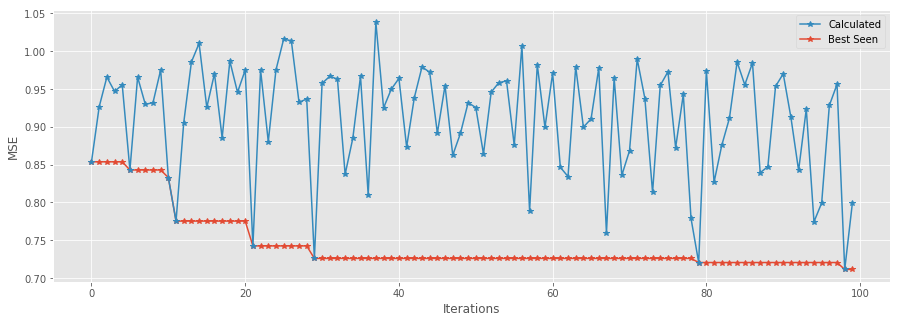

In [51]:
best_model_2 = tf.keras.models.load_model(path + "best_model_2.h5")
results = pd.read_csv(path + "AutoML_2.csv")
results = results[results["Status"]=="COMPLETED"]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
actual, = plt.plot(np.array(results.Objective),'*-')

plt.legend([actual, best],
           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()


In [52]:
best_model_2.summary()
best_model_2.evaluate(X_train, y_train)
best_model_2.evaluate(X_val, y_val)

Model: "model_198"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_199 (InputLayer)       [(None, 730, 1)]          0         
_________________________________________________________________
lstm_198 (LSTM)              (None, 98)                39200     
_________________________________________________________________
dense_692 (Dense)            (None, 501)               49599     
_________________________________________________________________
dense_693 (Dense)            (None, 428)               214856    
_________________________________________________________________
dense_694 (Dense)            (None, 405)               173745    
_________________________________________________________________
dense_695 (Dense)            (None, 365)               148190    
Total params: 625,590
Trainable params: 625,590
Non-trainable params: 0
___________________________________________________

[0.7114577630291814, 0.6293735]

In [53]:
pred = best_model_2.predict(X_val)
valid = x_scaler.inverse_transform(y_val).reshape(y_val.shape[0],y_val.shape[1])
pred = x_scaler.inverse_transform(pred)

print("MAPE:",np.mean(list(map(np.mean,np.abs(pred - valid)/np.abs(valid)))))

MAPE: 0.1616835760214879


### Third Architecture

In [ ]:
#The number of epoch could also be an hyperparameter
# but to reduce the computation stress it has been 
# fixed to be 100, (on approximately 2000 data) it is sufficient,
# otherwise it will start overfitting a lot! 
def get_model_score(params, epochs=100, verbose=0):
    early = EarlyStopping(monitor='val_loss', patience=50, verbose=0)
    lr_decay = ReduceLROnPlateau(monitor='val_loss', 
                             patience=3, verbose=0, 
                             factor=0.5, min_lr=1e-5)
    initial = Input(shape=(INPUT_SIZE,1))

    x = LSTM(int(params['lstm_unit1']), activation='tanh', 
           return_sequences=True,
           kernel_regularizer=regularizers.l1(0.001),
           activity_regularizer=regularizers.l1(0.001))(initial)
    x = LSTM(int(params['lstm_unit2']), activation='tanh', 
           return_sequences=False,
           kernel_regularizer=regularizers.l1(0.001),
           activity_regularizer=regularizers.l1(0.001))(x)


    x = Dense(int(params["hidden_unit1"]), activation='relu')(x)
    x = Dense(int(params["hidden_unit2"]), activation='relu')(x)

    out = Dense(OUTPUT_SIZE, activation='linear')(x)

    model = Model(initial, out)

    model.compile(loss='mse',
                optimizer=optimizers.RMSprop(learning_rate=params["lr_init"]), 
                metrics=['mae'])

    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
            batch_size=int(params["batch_size"]), epochs=epochs, 
            callbacks=[lr_decay, early],
            verbose=verbose)
    return model, model.evaluate(X_val, y_val)[0], hist


parameters = [sherpa.Discrete('lstm_unit1',[20,250]),
              sherpa.Discrete('lstm_unit2',[20,250]),
              sherpa.Discrete('hidden_unit1',[256,512]),
              sherpa.Discrete('hidden_unit2',[256,512]),
              sherpa.Continuous('lr_init', [0.0005, 0.005]),
              sherpa.Ordinal(name='batch_size', range=[64, 128, 256])]
alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

best_score = 999999

for trial in study:
    start_time = time.time()
    
    model, score, hist = get_model_score(trial.parameters)
    
    if np.isnan(score):
        score = 999999
        print("Model Crashed or 'NaNed'")
      
    if score != 999999:
        study.add_observation(trial, iteration=1, objective=score)
        if score < best_score:
            model.save(path + "best_model_3.h5")
            best_model   = model
            best_score   = score
            best_history = hist
    else:
        del model #free RAM
    study.finalize(trial)
    if(trial.id % 10 == 0 or trial.id == 1):
        print("Trial:",trial.id, "|| Best Score: ", best_score, " || Took ",str(time.time()-start_time), "Seconds")
    study.results.to_csv(path + "AutoML_3.csv")

184/184 [==============================] - 0s 796us/sample - loss: 0.9161 - mae: 0.7009
Trial: 1 || Best Score:  0.9161044722018035  || Took  70.78274631500244 Seconds
184/184 [==============================] - 0s 1ms/sample - loss: 0.9182 - mae: 0.6998


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 961us/sample - loss: 0.8937 - mae: 0.6929


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 989us/sample - loss: 0.9365 - mae: 0.7135


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 969us/sample - loss: 0.8706 - mae: 0.6791


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 10 || Best Score:  0.8705829122792119  || Took  118.51182126998901 Seconds
184/184 [==============================] - 0s 975us/sample - loss: 0.9787 - mae: 0.7445


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9244 - mae: 0.7060


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 966us/sample - loss: 0.9680 - mae: 0.7367


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 794us/sample - loss: 0.9384 - mae: 0.7133


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 792us/sample - loss: 0.9504 - mae: 0.7140


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9061 - mae: 0.6975


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 977us/sample - loss: 0.9574 - mae: 0.7083


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 913us/sample - loss: 0.9022 - mae: 0.6940


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 925us/sample - loss: 0.9287 - mae: 0.7080


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 716us/sample - loss: 0.9176 - mae: 0.7050


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 20 || Best Score:  0.8705829122792119  || Took  51.81518578529358 Seconds
184/184 [==============================] - 0s 944us/sample - loss: 0.9517 - mae: 0.7366


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 813us/sample - loss: 0.8816 - mae: 0.6884


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 807us/sample - loss: 0.9072 - mae: 0.6921


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7241 - mae: 0.6277


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9763 - mae: 0.7423


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9406 - mae: 0.7181


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9136 - mae: 0.6962


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 957us/sample - loss: 0.8146 - mae: 0.6996


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 838us/sample - loss: 0.9813 - mae: 0.7169


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9821 - mae: 0.7467


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 30 || Best Score:  0.7241046584170797  || Took  176.48243618011475 Seconds
184/184 [==============================] - 0s 798us/sample - loss: 0.8895 - mae: 0.6912


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9252 - mae: 0.7005


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9182 - mae: 0.7000


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.8990 - mae: 0.6938


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9444 - mae: 0.7121


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 995us/sample - loss: 0.7170 - mae: 0.6256


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7244 - mae: 0.6278


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 886us/sample - loss: 0.9381 - mae: 0.7348


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9788 - mae: 0.7478


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 721us/sample - loss: 0.8935 - mae: 0.6935


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 40 || Best Score:  0.7170182025950887  || Took  56.586517095565796 Seconds
184/184 [==============================] - 0s 853us/sample - loss: 60.3414 - mae: 3.8969


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7239 - mae: 0.6278


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 996us/sample - loss: 0.9890 - mae: 0.7508


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 647us/sample - loss: 0.9173 - mae: 0.7041


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 889us/sample - loss: 0.9208 - mae: 0.7078


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 990us/sample - loss: 0.9001 - mae: 0.6935


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 863us/sample - loss: 0.9853 - mae: 0.7445


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9993 - mae: 0.7563


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9434 - mae: 0.7122


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 758us/sample - loss: 0.9710 - mae: 0.7420


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 50 || Best Score:  0.7170182025950887  || Took  122.32126092910767 Seconds
184/184 [==============================] - 0s 1ms/sample - loss: 0.9927 - mae: 0.7560


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7237 - mae: 0.6278


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.8153 - mae: 0.6925


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9549 - mae: 0.7247


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 992us/sample - loss: 0.9378 - mae: 0.7120


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 991us/sample - loss: 0.9307 - mae: 0.7125


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 767us/sample - loss: 0.8809 - mae: 0.6904


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 982us/sample - loss: 0.9465 - mae: 0.7180


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 1.2122 - mae: 0.6261


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 997us/sample - loss: 0.9715 - mae: 0.7352


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 60 || Best Score:  0.7170182025950887  || Took  124.35470008850098 Seconds
184/184 [==============================] - 0s 724us/sample - loss: 4.0958 - mae: 1.0878


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7541 - mae: 0.6265


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 862us/sample - loss: 0.7237 - mae: 0.6278


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9975 - mae: 0.7430


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 996us/sample - loss: 0.9516 - mae: 0.6958


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7678 - mae: 0.6780


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9231 - mae: 0.7064


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7242 - mae: 0.6278


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 868us/sample - loss: 0.9361 - mae: 0.7218


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 810us/sample - loss: 0.9314 - mae: 0.7124


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 70 || Best Score:  0.7170182025950887  || Took  72.45908784866333 Seconds
184/184 [==============================] - 0s 1ms/sample - loss: 0.8469 - mae: 0.6837


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9904 - mae: 0.7482


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 811us/sample - loss: 0.9813 - mae: 0.7523


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9360 - mae: 0.7106


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 1.0035 - mae: 0.7492


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7672 - mae: 0.6276


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 867us/sample - loss: 0.8775 - mae: 0.6928


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7245 - mae: 0.6279


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9234 - mae: 0.7066


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 929us/sample - loss: 0.9866 - mae: 0.7522


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 80 || Best Score:  0.7170182025950887  || Took  257.8080961704254 Seconds
184/184 [==============================] - 0s 1ms/sample - loss: 0.9510 - mae: 0.7236


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7245 - mae: 0.6277


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7239 - mae: 0.6278


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7240 - mae: 0.6278


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7247 - mae: 0.6278


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7239 - mae: 0.6277


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9124 - mae: 0.7267


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 877us/sample - loss: 0.9988 - mae: 0.7088


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.8888 - mae: 0.6953


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 844us/sample - loss: 0.9542 - mae: 0.7237


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Trial: 90 || Best Score:  0.7170182025950887  || Took  72.00209593772888 Seconds
184/184 [==============================] - 0s 1ms/sample - loss: 0.9130 - mae: 0.7026


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 781us/sample - loss: 0.9112 - mae: 0.7043


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 761us/sample - loss: 0.9084 - mae: 0.7013


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 689us/sample - loss: 0.8650 - mae: 0.6813


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9964 - mae: 0.7567


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 737us/sample - loss: 0.9502 - mae: 0.7195


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 903us/sample - loss: 0.8993 - mae: 0.6949


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 656us/sample - loss: 0.9377 - mae: 0.7218


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.7243 - mae: 0.6278


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


184/184 [==============================] - 0s 1ms/sample - loss: 0.9563 - mae: 0.7116
Trial: 100 || Best Score:  0.7170182025950887  || Took  231.1123993396759 Seconds


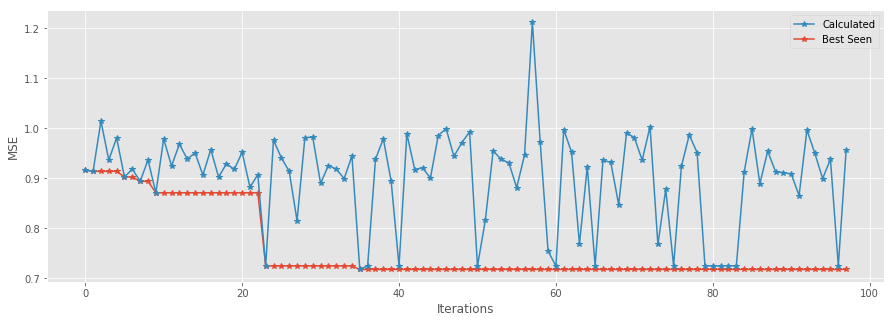

In [59]:
best_model_3 = tf.keras.models.load_model(path + "best_model_3.h5")
results = pd.read_csv(path + "AutoML_3.csv")
results = results[results["Status"]=="COMPLETED"]
results = results[results["Objective"] < 2]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
actual, = plt.plot(np.array(results.Objective),'*-')

plt.legend([actual, best],
           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()


In [60]:
best_model_3.summary()
best_model_3.evaluate(X_train, y_train)
best_model_3.evaluate(X_val, y_val)

Model: "model_235"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_236 (InputLayer)       [(None, 730, 1)]          0         
_________________________________________________________________
lstm_270 (LSTM)              (None, 730, 209)          176396    
_________________________________________________________________
lstm_271 (LSTM)              (None, 156)               228384    
_________________________________________________________________
dense_805 (Dense)            (None, 280)               43960     
_________________________________________________________________
dense_806 (Dense)            (None, 270)               75870     
_________________________________________________________________
dense_807 (Dense)            (None, 365)               98915     
Total params: 623,525
Trainable params: 623,525
Non-trainable params: 0
___________________________________________________

[0.7170246580372686, 0.6256028]

In [61]:
pred = best_model_3.predict(X_val)
valid = x_scaler.inverse_transform(y_val).reshape(y_val.shape[0],y_val.shape[1])
pred = x_scaler.inverse_transform(pred)

print("MAPE:",np.mean(list(map(np.mean,np.abs(pred - valid)/np.abs(valid)))))

MAPE: 0.16254861152731434


### Best performance is the first one:

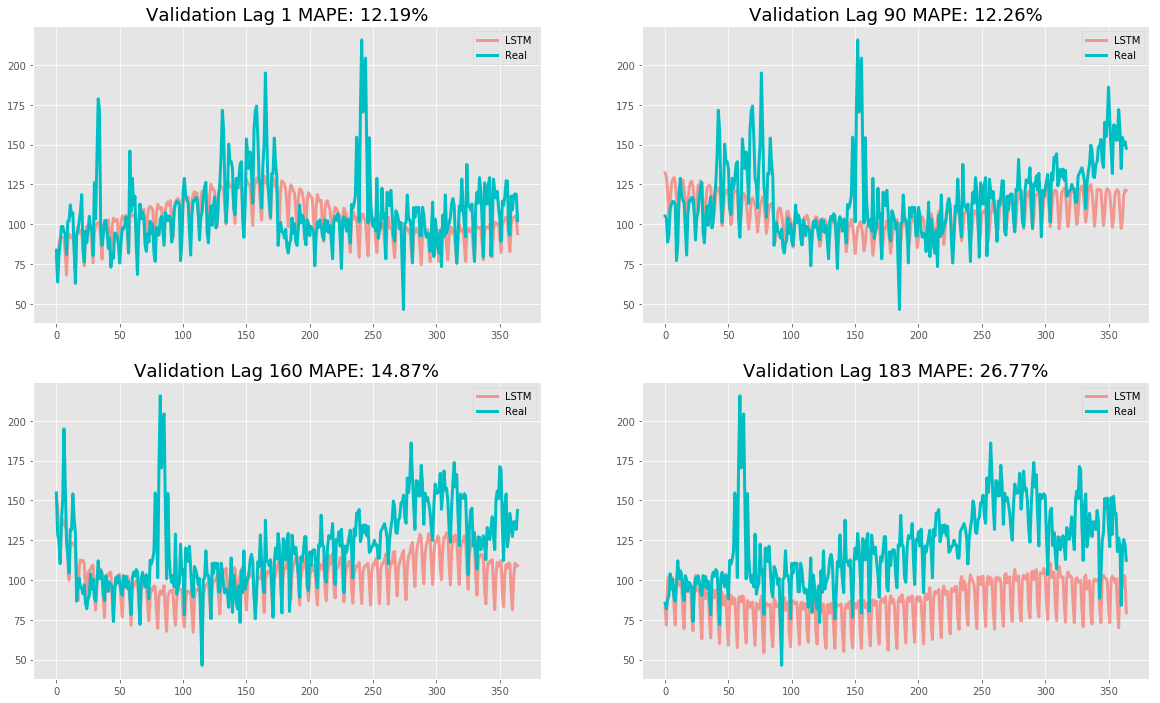

In [52]:
plt.figure(figsize=(20,12))
i = 1
y_val_i = y_val[i]
X_v_i = np.expand_dims(X_val[i], axis=0)

pred_i = best_model.predict(X_v_i).reshape(y_val_i.shape[0],y_val_i.shape[1])
pred_i = x_scaler.inverse_transform(best_model.predict(X_v_i)).reshape(y_val_i.shape[0],y_val_i.shape[1])
y_val_i = x_scaler.inverse_transform(y_val[i])

mape = np.mean(np.abs(y_val_i - pred_i)/y_val_i)

plt.subplot(2,2,1)
pred_, = plt.plot(pred_i, color="#F8766D",linewidth=3,alpha=0.7)
val_, = plt.plot(y_val_i, color="#00BFC4",linewidth=3)
plt.legend([pred_,val_],["LSTM","Real"])
plt.title("Validation Lag " + str(i) +" MAPE: " + str(round(mape*100,2)) + "%", fontsize=18)

i = 90
y_val_i = y_val[i]
X_v_i = np.expand_dims(X_val[i], axis=0)

pred_i = best_model.predict(X_v_i).reshape(y_val_i.shape[0],y_val_i.shape[1])
pred_i = x_scaler.inverse_transform(best_model.predict(X_v_i)).reshape(y_val_i.shape[0],y_val_i.shape[1])
y_val_i = x_scaler.inverse_transform(y_val[i])

mape = np.mean(np.abs(y_val_i - pred_i)/y_val_i)

plt.subplot(2,2,2)
pred_, = plt.plot(pred_i, color="#F8766D", linewidth=3,alpha=0.7)
val_, = plt.plot(y_val_i, color="#00BFC4", linewidth=3)
plt.legend([pred_,val_],["LSTM","Real"])
plt.title("Validation Lag " + str(i) +" MAPE: " + str(round(mape*100,2)) + "%", fontsize=18)


i = 160
y_val_i = y_val[i]
X_v_i = np.expand_dims(X_val[i], axis=0)

pred_i = best_model.predict(X_v_i).reshape(y_val_i.shape[0],y_val_i.shape[1])
pred_i = x_scaler.inverse_transform(best_model.predict(X_v_i)).reshape(y_val_i.shape[0],y_val_i.shape[1])
y_val_i = x_scaler.inverse_transform(y_val[i])

mape = np.mean(np.abs(y_val_i - pred_i)/y_val_i)

plt.subplot(2,2,3)
pred_, = plt.plot(pred_i, color="#F8766D",linewidth=3,alpha=0.7)
val_, = plt.plot(y_val_i, color="#00BFC4",linewidth=3)
plt.legend([pred_,val_],["LSTM","Real"])
plt.title("Validation Lag " + str(i) +" MAPE: " + str(round(mape*100,2)) + "%", fontsize=18)


i = 183
y_val_i = y_val[i]
X_v_i = np.expand_dims(X_val[i], axis=0)

pred_i = best_model.predict(X_v_i).reshape(y_val_i.shape[0],y_val_i.shape[1])
pred_i = x_scaler.inverse_transform(best_model.predict(X_v_i)).reshape(y_val_i.shape[0],y_val_i.shape[1])
y_val_i = x_scaler.inverse_transform(y_val[i])

mape = np.mean(np.abs(y_val_i - pred_i)/y_val_i)

plt.subplot(2,2,4)
pred_, = plt.plot(pred_i, color="#F8766D",linewidth=3,alpha=0.7)
val_, = plt.plot(y_val_i, color="#00BFC4",linewidth=3)
plt.legend([pred_,val_],["LSTM","Real"])
plt.title("Validation Lag " + str(i) +" MAPE: " + str(round(mape*100,2)) + "%", fontsize=18)
plt.savefig("imgs/forecast_lstm.png", bbox_inches='tight', pad_inches=0)
plt.show()

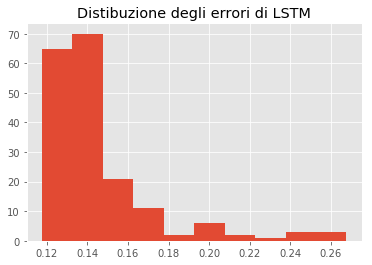

In [43]:
pred = best_model.predict(X_val)
valid = x_scaler.inverse_transform(y_val).reshape(y_val.shape[0],y_val.shape[1])
pred = x_scaler.inverse_transform(pred)

plt.hist(list(map(np.mean,np.abs(pred - valid)/np.abs(valid))))
plt.title("Distibuzione degli errori di LSTM")
plt.show()

In [44]:
#Training performance for the best model
pred = best_model.predict(X_train)
y_train_ = x_scaler.inverse_transform(y_train).reshape(y_train.shape[0],y_train.shape[1])
pred = x_scaler.inverse_transform(pred)

print("MAPE:",np.mean(list(map(np.mean,np.abs(pred - y_train_)/np.abs(y_train_)))))

MAPE: 0.13816177261444312


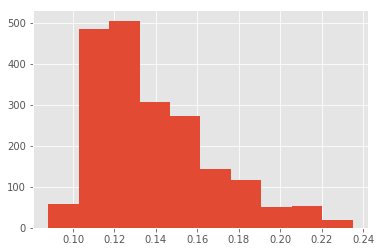

In [49]:
plt.hist(list(map(np.mean,np.abs(pred - y_train_)/np.abs(y_train_))))
plt.show()